In [1]:
#!pip install control

In [2]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss, ctrb, obsv
from control.matlab import lsim

# **The cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient, and $F:|F|\leq 10\,\text{N}$ is the force applied to cart's center of mass.

# 1. Clearly define an optimal control problem for pole balancing

Pole balancing is a classic problem in control theory where the goal is to maintain the balance of an inverted pendulum (pole) on a moving platform. The optimal control problem for pole balancing involves finding a control policy that minimizes a cost function while ensuring the stability of the system. Here's a more detailed formulation:

**System dynamics**

Consider a simple inverted pendulum system with a cart that can move horizontally. The state of the system is described by the position of the cart ($p_c$) and the angle of the pole $\theta$). The dynamics of the system can be modeled using differential equations, such as the nonlinear equations of motion for an inverted pendulum.

**Objective**

Define a cost function that captures the performance and stability of the system. The objective is to find a control policy that minimizes this cost function over a specified time horizon.


The optimal control problem can be formulated as finding the control input $u(t)$ that minimizes the cost function while satisfying the system dynamics and any constraints:

$min_{⁡u(t)}J(x(t),\theta(t),u(t))$

subject to the dynamics of the system and any imposed constraints.

Solving this optimal control problem will yield a control policy that stabilizes the inverted pendulum while satisfying the specified performance criteria.

# 2. Is the LQR applicable in its simple form on the system? If not what is missed?




LQR can be applied on the pole balancing problem, but only if we can linearize the system.

# 3. Design an LQR for the linearized version of the cart and pole obtained in the previous hands-on. Justify all the design choices and perform all the required checks

In [3]:
def cart_and_pole_lin(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #tetap
    dxdt[1] = 0 #teta2p
    for i in range(len(x)):
        dxdt[1] += theta2p_lin[i]*(x[i] - xeq[i])
    dxdt[2] = x[3] #xp
    dxdt[3] = 0 #x2p
    for i in range(len(x)):
        dxdt[3] += x2p_lin[i]*(x[i] - xeq[i])
    return dxdt

with open('linearized_model.pkl', 'rb') as file: 
    linearized_model = pickle.load(file) 

In [4]:
theta2p_linA = linearized_model["theta2p_linA"]
x2p_linA = linearized_model["x2p_linA"]

Keeping into account that the state vector looks like this:

$x = \left( \begin{array}{ccc}
                \theta \\
                \dot \theta \\
                p_c \\
                \dot p_c
\end{array} \right)
=
\left( \begin{array}{ccc}
                  x_1 \\
                  x_2 \\
                  x_3 \\
                  x_4
\end{array} \right)$

In [5]:
A = np.array([
    [0, 1, 0, 0],
    theta2p_linA,
    [0, 0, 0, 1],
    x2p_linA
])
B = np.array([
    [0],
    [linearized_model["theta2p_linB"]],
    [0],
    [linearized_model["x2p_linB"]]
])
C = np.array([
    [1,  0,  0,  0],
    [0,  1,  0,  0],
    [0,  0,  1,  0],
    [0,  0,  0,  1]
])
D = 0

Checking for reachability and controllability is important in the context of LQR control because LQR assumes that the system is fully controllable. If the system is not controllable or reachable, the optimal control design may not be achievable or may not lead to desirable performance.

To do so we have to build the controllability and observability matrices and check their rank to be maximum (in this case 4).

In [6]:
ctrb_matrix = ctrb(A, B)
print(np.linalg.matrix_rank(ctrb_matrix))
obsv_matrix = obsv(A, C)
print(np.linalg.matrix_rank(obsv_matrix))

4
4


The check is passed, we can now step into defining our LQR control.

In [7]:
Q = np.array([
    [1,  0,  0,  0],
    [0,  0,  0,  0],
    [0,  0,  10, 0],
    [0,  0,  0,  0]
])
R = 10

K, S, E = lqr(A, B, Q, R)

# 4.    Simulate the linearized cart and pole system controlled by an LQR. Plot the significant behaviors

To simulate the linearized model, we have to feed a discretised step input (the first entry will be set to 10 and everything else to 0) and see if our controller will bring back the system into its equilibrium state.

In [8]:
A_c = A - B * K
S = ss(A_c, B, C, D)

time_step=0.02
time_sim=np.arange(0.0, 20, time_step)

uvec = np.zeros_like(time_sim)
uvec[0] = 10

In [9]:
yout, T, xout = lsim(S, uvec, time_sim)

Text(0.5, 1.0, 'theta(t)')

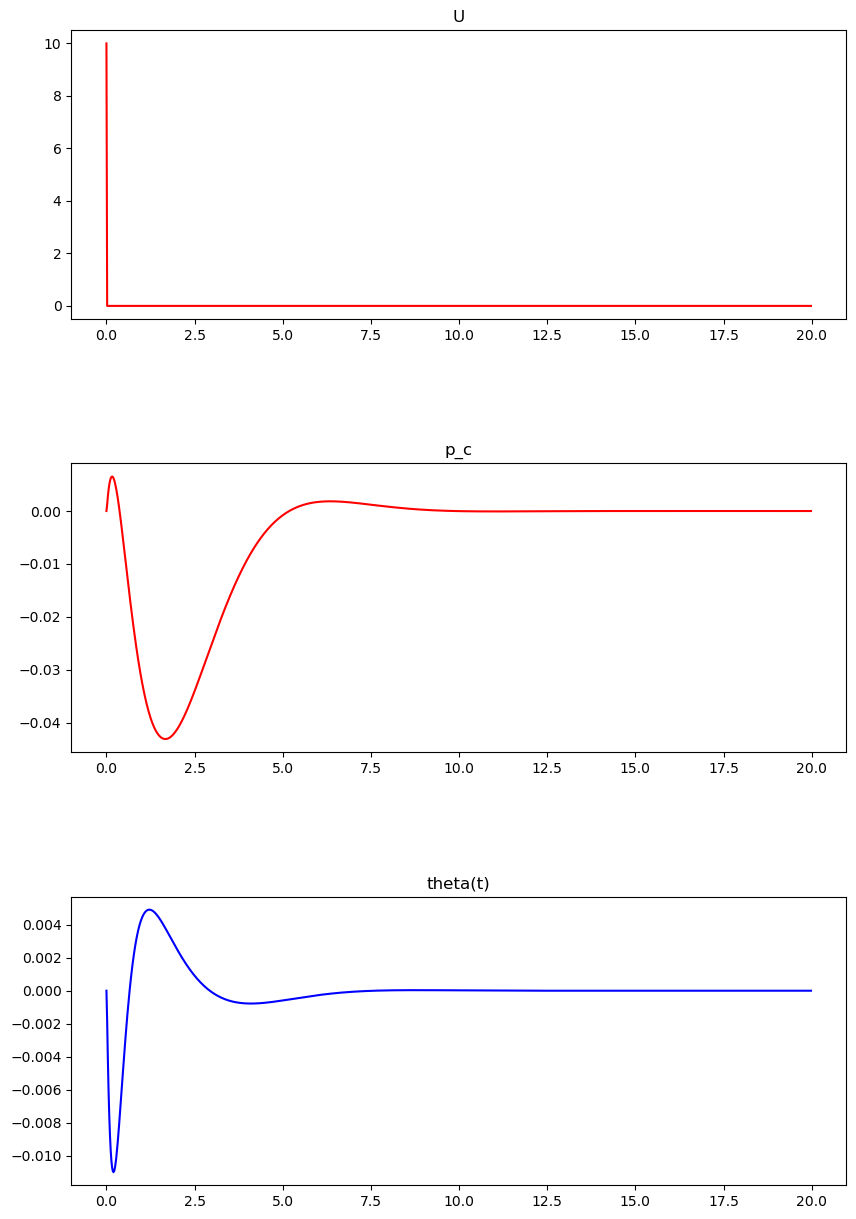

In [10]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, xout[:,2], 'r', label='U(t)')
axs[1].set_title("p_c")

axs[2].plot(time_sim, xout[:,0], 'b')
axs[2].set_title("theta(t)")

We can be satisfied with the result of our simulation

# 5.  Simulate the non-linear cart and pole system controlled by the previously obtained LQR. Plot the significant behaviors

To simulate the non-linear model we have to make use of the `odeint` function.

In [11]:
t0_odeint=0
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])
X_odeint=[x0_odeint]

g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

# let's set the input force to 0
F = 0 # N

In [12]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

In [13]:
for i in range(len(uvec)):
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    F = uvec[i]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)
    
    if i < len(uvec)-1:
        uvec[i+1] = -(K * x0_odeint[np.newaxis].T)[0][0]

In [14]:
t1_odeint = t0_odeint+0.02
t_odeint = np.array([t0_odeint, t1_odeint])
F = uvec[i]
x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
x0_odeint = x_odeint[1]
X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)

In [15]:
x0_odeint

array([ 4.55007309e-08, -4.27455658e-08, -2.22187571e-07, -1.75985115e-07])

Text(0.5, 1.0, 'theta(t)')

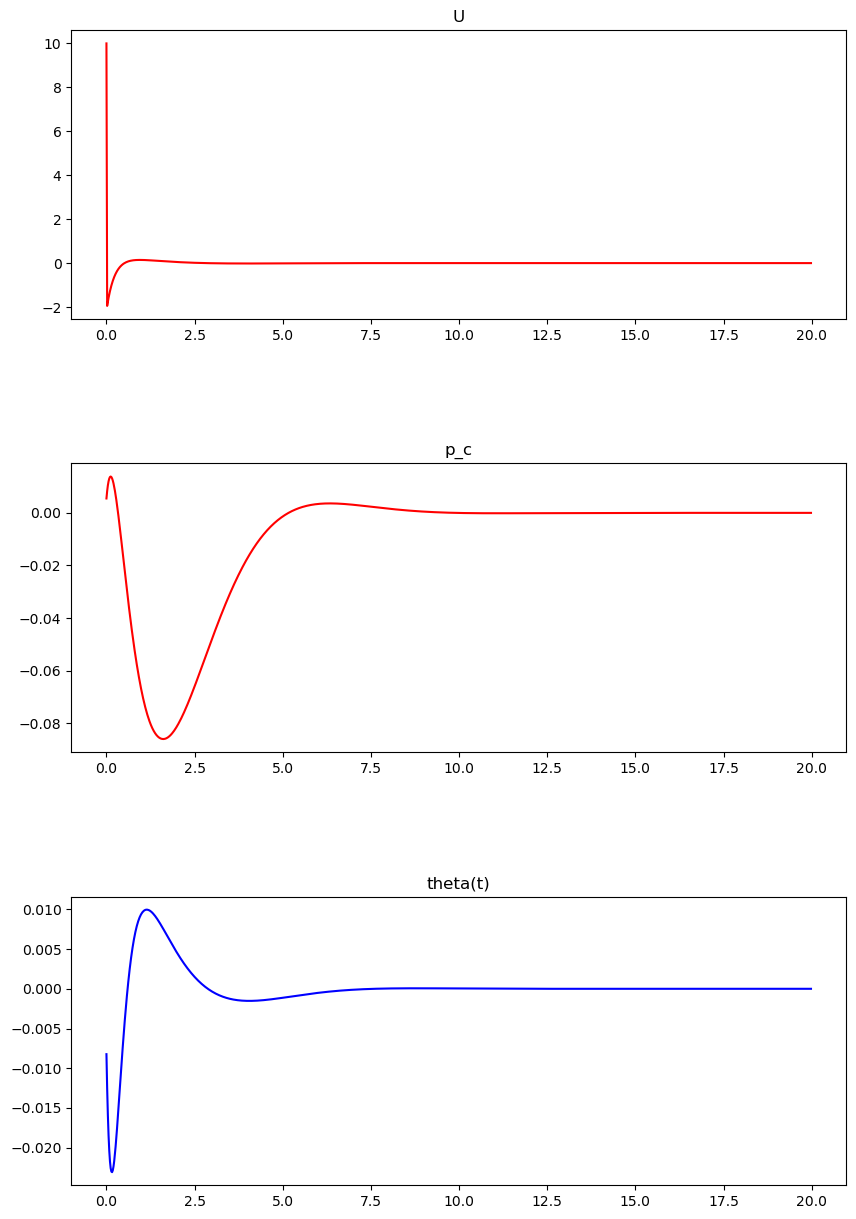

In [19]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[2:,2], 'r', label='U(t)')
axs[1].set_title("p_c")

axs[2].plot(time_sim, X_odeint[2:,0], 'b')
axs[2].set_title("theta(t)")

# 6. Comment results obtained in the two simulations

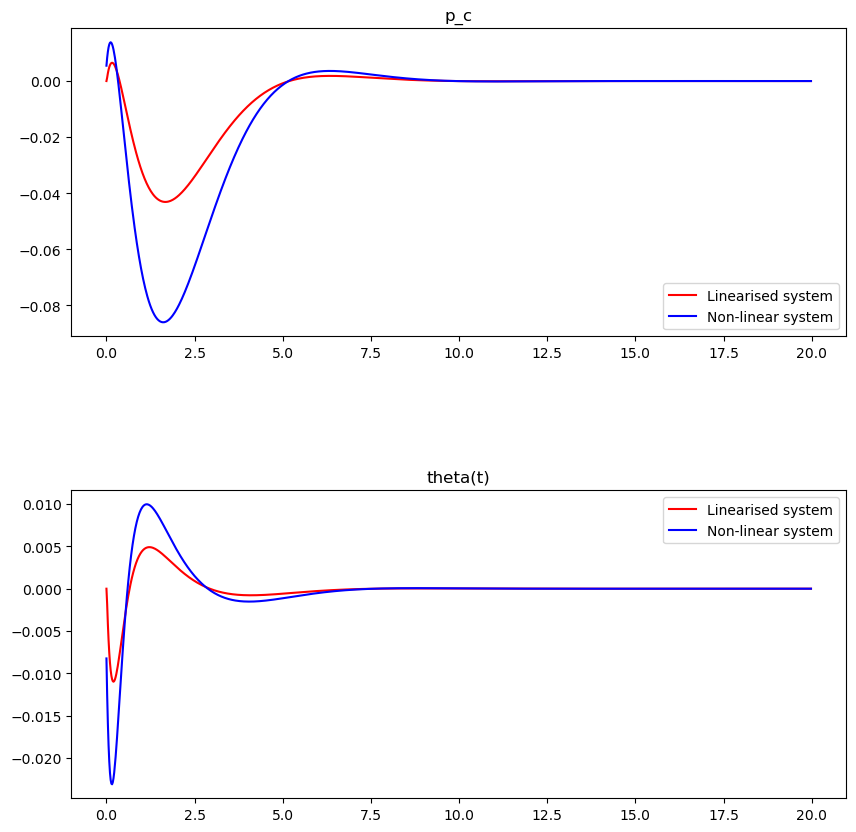

In [26]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, xout[:,2], 'r', label='U(t)')
axs[0].plot(time_sim, X_odeint[2:,2], 'b', label='U(t)')
axs[0].set_title("p_c")
axs[0].legend(["Linearised system", "Non-linear system"])

axs[1].plot(time_sim, xout[:,0], 'r')
axs[1].plot(time_sim, X_odeint[2:,0], 'b')
axs[1].set_title("theta(t)")
axs[1].legend(["Linearised system", "Non-linear system"])

The gotten results are different because the matrices of the discretised system are only capable of returning a sufficiently good approximation of the system as we are close to the equilibrium point. We can notice that as the response is moving farther away from the equilibrium, the two curves are diverging and as we are getting closer they become overlapping.